In [1]:
# coding=utf-8
import math
from scapy.all import *
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from scipy.stats import t
from math import sqrt
from math import pow
import requests
import os
import IP2Location

IP_SERVICE_URL = 'https://freegeoip.net/json/{}'

hosts = dict([('www.uq.edu.au','130.102.131.70'),('udsu.ru', '94.25.116.37'), ('site.u.pereslavl.ru','95.129.137.162'),('www.kstu.kz','85.29.137.233'), ('keu.kz','46.235.86.164'), ('unak.is','130.208.224.102'),('www.fu-berlin.de','160.45.170.10'),('kgiu.kz','195.210.46.14'),('www.uae.ma','159.253.148.195'),('unis.no','158.39.149.250'),('bifrost.is','185.118.33.147'),('birmingham.ac.uk','147.188.218.91')])

api_key = '49f2da642556dfd205946d37e9e7ebbd61d1e74ea737f153b597c212ea80302e'

DEFAULT_RTT_VALUE = 0

ATTEMPS = 30

In [20]:
from __future__ import print_function, unicode_literals, with_statement
import argparse
import contextlib
import requests
import sys
import csv
import matplotlib
# Anti-Grain Geometry (AGG) backend so PyGeoIpMap can be used 'headless'
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pygeoip


def get_ip(ip_file):
    """
    Returns a list of IP addresses from a file containing one IP per line.
    """
    with contextlib.closing(ip_file):
        return [line.strip() for line in ip_file]


def get_lat_lon(ip_list=[], lats=[], lons=[]):
    """
    This function connects to the FreeGeoIP web service to get info from
    a list of IP addresses.
    Returns two lists (latitude and longitude).
    """
    print("Processing {} IPs...".format(len(ip_list)))
    for ip in ip_list:
        r = requests.get("https://freegeoip.net/json/" + ip)
        json_response = r.json()
        if json_response['latitude'] and json_response['longitude']:
            lats.append(json_response['latitude'])
            lons.append(json_response['longitude'])
    return lats, lons


def geoip_lat_lon(gi, ip_list=[], lats=[], lons=[]):
    """
    This function uses the MaxMind library and databases to geolocate IP addresses
    Returns two lists (latitude and longitude).
    """
    for ip in ip_list:
        try:
            r = gi.record_by_addr(ip)
        except Exception:
            print("Unable to locate IP: %s" % ip)
            continue
        if r is not None:
            lats.append(r['latitude'])
            lons.append(r['longitude'])
    return lats, lons


def get_lat_lon_from_csv(csv_file, lats=[], lons=[]):
    """
    Retrieves the last two rows of a CSV formatted file to use as latitude
    and longitude.
    Returns two lists (latitudes and longitudes).
    Example CSV file:
    119.80.39.54, Beijing, China, 39.9289, 116.3883
    101.44.1.135, Shanghai, China, 31.0456, 121.3997
    219.144.17.74, Xian, China, 34.2583, 108.9286
    64.27.26.7, Los Angeles, United States, 34.053, -118.2642
    """
    with contextlib.closing(csv_file):
        reader = csv.reader(csv_file)
        for row in reader:
            lats.append(row[-2])
            lons.append(row[-1])

    return lats, lons


def generate_map(output, lats=[], lons=[], wesn=None):
    """
    Using Basemap and the matplotlib toolkit, this function generates a map and
    puts a red dot at the location of every IP addresses found in the list.
    The map is then saved in the file specified in `output`.
    """
    
    plt.clf()
    print("Generating map and saving it to {}".format(output))
    if wesn:
        wesn = [float(i) for i in wesn.split('/')]
        m = Basemap(projection='cyl', resolution='l',
                llcrnrlon=wesn[0], llcrnrlat=wesn[2],
                urcrnrlon=wesn[1], urcrnrlat=wesn[3])
    else:
        m = Basemap(projection='cyl', resolution='l')
    m.bluemarble()

    x, y = m(lons, lats)
    
    m.plot(x, y, 40, 40, color='y')
    m.scatter(x, y, s=3, color='#ff0000', marker='o', alpha=0.3) #, alpha=0.3
    plt.savefig(output, dpi=300, bbox_inches='tight')
    plt.close()

def graficar_ruta(ruta, nombre_imagen):
    gi = pygeoip.GeoIP('GeoLiteCity.dat')
    lats, lons = geoip_lat_lon(gi, ruta)
    generate_map(nombre_imagen, lats, lons) #, wesn='-12/45/30/65'

In [3]:
def toLatex(df):
    from IPython.display import Latex
    Latex(outliers.to_latex())

In [4]:
def ipCountryCode(ip):    
    resp = requests.get(IP_SERVICE_URL.format(ip))
    if resp.status_code != 200:
        raise ApiError('GET /tasks/ {}'.format(resp.status_code))
    return resp.json()['country_code']

In [5]:
def modified_thompson(n):
    alpha = 0.025
    t_critical = t.ppf(1-alpha, n-2)
    return (t_critical*(n-1)) / (sqrt(n) * sqrt(n-2 + pow(t_critical,2)))  

In [6]:
def enviar_paquete(host, time_to_live):
    packet = IP(dst=host, ttl=time_to_live) / ICMP()
    res = sr(packet, timeout=1, verbose=0)
    return res[0][ICMP]

In [7]:
def route(df):
    return df[df['ip'] != 'empty']['ip'].unique()

In [8]:
def calculateOutliers(rtt_df):
    descriptions = rtt_df.describe().T
    mean = descriptions['mean']
    std = descriptions['std']
    zrtt = (rtt_df-mean)/std
    n = len(zrtt)
    thomson_value = modified_thompson(n)
    abszrtt = abs(zrtt)
    return abszrtt[abszrtt['rtt'] > thomson_value], zrtt

In [9]:
def trace_route(hosts):
    
    ips_countrycode = {}
    df_list = []
    rtt_df_list = []
    outliers_df_list = []
    zrtt_df_list = []

    for host in hosts:
        hops = []
        ttl_without_response = []
        ip = hosts[host]
        for i in range(0,ATTEMPS):
            tipo = 11
            ttl = 1
            last_rtt = 0
            while (tipo!=0 and ttl < 30):
                if (not ttl in ttl_without_response):
                    ti = time.time()
                    res1 = enviar_paquete(ip, ttl)
                    tf = time.time()
                    rtt = tf-ti
                    if (len(res1) > 0):
                        tipo = res1[0][1].type
                        src = res1[0][1].src
                        countryCode = None
                        if(src in ips_countrycode):
                            countryCode = ips_countrycode[src]
                        else:
                            countryCode = ipCountryCode(src)
                            ips_countrycode[src] = countryCode
                        if (tipo > 0):
                            hops.append([host,ttl,i,src,countryCode, max(0,rtt-last_rtt)])
                        else:
                            hops.append([host,ttl,i,src,countryCode, max(0,rtt-last_rtt)])
                        last_rtt = rtt
                    else:
                        hops.append([host,ttl,i,"empty","empty",DEFAULT_RTT_VALUE])
                        ttl_without_response.append(ttl)
                ttl = ttl + 1

        df = pd.DataFrame(hops,columns=['host','ttl','i','ip','cc','rtt'])
        indexed = df.set_index(['host','ttl','i','ip','cc'])
        rtt_df = indexed.groupby(level=['host','ttl','ip','cc']).mean()
        outliers_df, zrtt_df = calculateOutliers(rtt_df)
        rtt_df_list.append(rtt_df)
        outliers_df_list.append(outliers_df)
        zrtt_df_list.append(zrtt_df)
        df_list.append(df)
        graficar_ruta(route(df),'route[{}].png'.format(host))
    
    return df_list, rtt_df_list, outliers_df_list, zrtt_df_list

In [10]:
%%time
df_list, rtt_df_list, outliers_df_list, zrtt_df_list = trace_route(hosts)

Generating map and saving it to route[www.uq.edu.au].png


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


Generating map and saving it to route[unis.no].png
Generating map and saving it to route[www.kstu.kz].png
Generating map and saving it to route[birmingham.ac.uk].png
Generating map and saving it to route[keu.kz].png
Generating map and saving it to route[bifrost.is].png
Generating map and saving it to route[unak.is].png
Generating map and saving it to route[site.u.pereslavl.ru].png
Generating map and saving it to route[www.fu-berlin.de].png
Generating map and saving it to route[udsu.ru].png
Generating map and saving it to route[kgiu.kz].png
Generating map and saving it to route[www.uae.ma].png
CPU times: user 1min 52s, sys: 59.6 s, total: 2min 51s
Wall time: 42min 22s


# Guardo los archivos cvs

In [33]:
for df in df_list:
    host = df['host'].unique()[0]
    df.to_csv('./df-csv/'+host, index=False, header=None)

# Leo los archivos  csv y creo los dataframe

In [55]:
from os import listdir

def readDataFrames():
    df_map = {}
    rtt_df_map = {}
    outliers_df_map = {}
    zrtt_df_map = {}

    for host in listdir('./df-csv'):
        df = pd.read_csv('./df-csv/'+host, header=None, names=['host','ttl','i','ip','cc','rtt'])
        df_map[host] = df
        indexed = df.set_index(['host','ttl','i','ip','cc'])
        rtt_df = indexed.groupby(level=['host','ttl','ip','cc']).mean()
        outliers_df, zrtt_df = calculateOutliers(rtt_df)
        outliers_df_map[host] = outliers_df
        zrtt_df_map[host] = zrtt_df
        rtt_df_map[host] = rtt_df


    return df_map, rtt_df_map, outliers_df_map, zrtt_df_map


In [56]:
def graficarTodasLasCorridas(df_map):
    for host in df_map:
        graficar_ruta(route(df), './grafico-rutas/'+host+'.png')

In [ ]:
df_map, rtt_df_map, outliers_df_map, zrtt_df_map = readDataFrames()

graficarTodasLasCorridas(df_map)

Generating map and saving it to ./grafico-rutas/www.uq.edu.au.png
Generating map and saving it to ./grafico-rutas/unis.no.png
Generating map and saving it to ./grafico-rutas/www.kstu.kz.png
Generating map and saving it to ./grafico-rutas/birmingham.ac.uk.png
Generating map and saving it to ./grafico-rutas/keu.kz.png


array([[<matplotlib.axes.AxesSubplot object at 0x7f90e7db0490>]], dtype=object)

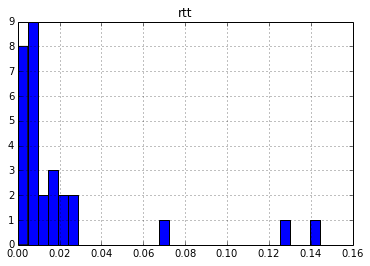

In [26]:
%matplotlib inline
pd.DataFrame.hist(rtt_df_list[0], bins=30)

In [49]:
df = pd.read_csv('./df-csv/bifrost.is', header=None, names=['host','ttl','i','ip','cc','rtt'])
indexed = df.set_index(['host','ttl','i','ip','cc'])
indexed

rtt
host       ttl i  ip             cc             
bifrost.is 1   0  empty          empty  0.000000
           2   0  empty          empty  0.000000
           3   0  empty          empty  0.000000
           4   0  empty          empty  0.000000
           5   0  200.89.161.133 AR     0.076023
           6   0  200.89.165.130 AR     0.003693
           7   0  200.89.165.222 AR     0.030208
           8   0  185.70.203.32  IT     0.000000
           9   0  89.221.41.171  IT     0.122046
           10  0  89.221.41.171  IT     0.000000
           11  0  154.54.9.17    US     0.003103
           12  0  154.54.24.233  US     0.002802
           13  0  154.54.24.197  US     0.001222
           14  0  154.54.24.221  US     0.016301
           15  0  154.54.40.109  US     0.011807
           16  0  154.54.42.86   US     0.077076
           17  0  154.54.57.162  US     0.011167
           18  0  130.117.2.110  NaN    0.000000
           19  0  149.6.98.110   US     0.000000
           20  0  31.15.113.2    IS     0.013678
           21  0  31.15.113.1    IS     0.051892
           22  0  31.15.115.41   IS     0.000000
           23  0  176.10.35.233  IS     0.000000
           24  0  176.10.35.234  IS     0.011831
           25  0  185.118.33.147 IS     0.014547
           5   1  200.89.161.133 AR     0.061721
           6   1  200.89.165.130 AR     0.011566
           7   1  200.89.165.222 AR     0.006606
           8   1  185.70.203.32  IT     0.000000
           9   1  89.221.41.171  IT     0.120538
...                                          ...
           17  28 154.54.57.162  US     0.009475
           18  28 130.117.2.110  NaN    0.000000
           19  28 149.6.98.110   US     0.012017
           20  28 31.15.113.2    IS     0.002095
           21  28 31.15.113.1    IS     0.012013
           22  28 31.15.115.41   IS     0.000000
           23  28 176.10.35.233  IS     0.023097
           24  28 176.10.35.234  IS     0.000000
           25  28 185.118.33.147 IS     0.012142
           5   29 200.89.161.133 AR     0.067714
           6   29 200.89.165.130 AR     0.004229
           7   29 200.89.165.222 AR     0.000016
           8   29 185.70.203.32  IT     0.000000
           9   29 89.221.41.171  IT     0.124257
           10  29 89.221.41.171  IT     0.008026
           11  29 154.54.9.17    US     0.015686
           12  29 154.54.24.233  US     0.000000
           13  29 154.54.24.197  US     0.012098
           14  29 154.54.24.221  US     0.000000
           15  29 154.54.40.109  US     0.000000
           16  29 154.54.42.86   US     0.108005
           17  29 154.54.57.162  US     0.000000
           18  29 130.117.2.110  NaN    0.000000
           19  29 149.6.98.110   US     0.000000
           20  29 31.15.113.2    IS     0.004276
           21  29 31.15.113.1    IS     0.007953
           22  29 31.15.115.41   IS     0.039959
           23  29 176.10.35.233  IS     0.000000
           24  29 176.10.35.234  IS     0.007116
           25  29 185.118.33.147 IS     0.002361

[634 rows x 1 columns]

In [105]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
from __future__ import print_function, unicode_literals, with_statement
import argparse
import contextlib
import requests
import sys
import csv
import matplotlib
# Anti-Grain Geometry (AGG) backend so PyGeoIpMap can be used 'headless'
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pygeoip


def get_ip(ip_file):
    """
    Returns a list of IP addresses from a file containing one IP per line.
    """
    with contextlib.closing(ip_file):
        return [line.strip() for line in ip_file]


def get_lat_lon(ip_list=[], lats=[], lons=[]):
    """
    This function connects to the FreeGeoIP web service to get info from
    a list of IP addresses.
    Returns two lists (latitude and longitude).
    """
    print("Processing {} IPs...".format(len(ip_list)))
    for ip in ip_list:
        r = requests.get("https://freegeoip.net/json/" + ip)
        json_response = r.json()
        print("{ip}, {region_name}, {country_name}, {latitude}, {longitude}".format(**json_response))
        if json_response['latitude'] and json_response['longitude']:
            lats.append(json_response['latitude'])
            lons.append(json_response['longitude'])
    return lats, lons


def geoip_lat_lon(gi, ip_list=[], lats=[], lons=[]):
    """
    This function uses the MaxMind library and databases to geolocate IP addresses
    Returns two lists (latitude and longitude).
    """
    print("Processing {} IPs...".format(len(ip_list)))
    for ip in ip_list:
        try:
            r = gi.record_by_addr(ip)
        except Exception:
            print("Unable to locate IP: %s" % ip)
            continue
        if r is not None:
            print("%s {country_code} {latitude}, {longitude}".format(**r) % ip)
            lats.append(r['latitude'])
            lons.append(r['longitude'])
    return lats, lons


def get_lat_lon_from_csv(csv_file, lats=[], lons=[]):
    """
    Retrieves the last two rows of a CSV formatted file to use as latitude
    and longitude.
    Returns two lists (latitudes and longitudes).
    Example CSV file:
    119.80.39.54, Beijing, China, 39.9289, 116.3883
    101.44.1.135, Shanghai, China, 31.0456, 121.3997
    219.144.17.74, Xian, China, 34.2583, 108.9286
    64.27.26.7, Los Angeles, United States, 34.053, -118.2642
    """
    with contextlib.closing(csv_file):
        reader = csv.reader(csv_file)
        for row in reader:
            lats.append(row[-2])
            lons.append(row[-1])

    return lats, lons


def generate_map(output, lats=[], lons=[], wesn=None):
    """
    Using Basemap and the matplotlib toolkit, this function generates a map and
    puts a red dot at the location of every IP addresses found in the list.
    The map is then saved in the file specified in `output`.
    """
    
    plt.clf()
    print("Generating map and saving it to {}".format(output))
    if wesn:
        wesn = [float(i) for i in wesn.split('/')]
        m = Basemap(projection='cyl', resolution='l',
                llcrnrlon=wesn[0], llcrnrlat=wesn[2],
                urcrnrlon=wesn[1], urcrnrlat=wesn[3])
    else:
        m = Basemap(projection='cyl', resolution='l')
    m.bluemarble()

    x, y = m(lons, lats)
    
    m.plot(x, y, 40, 40, color='y')
    m.scatter(x, y, s=3, color='#ff0000', marker='o', alpha=0.3) #, alpha=0.3
    
    plt.figure(figsize=(10,6), dpi=80)
    
    plt.show()

    plt.savefig(output, dpi=300, bbox_inches='tight')

def graficar_ruta(ruta, nombre_imagen):
    gi = pygeoip.GeoIP('GeoLiteCity.dat')
    lats, lons = geoip_lat_lon(gi, ruta)
    generate_map(nombre_imagen, lats, lons) #, wesn='-12/45/30/65'

Processing 25 IPs...
200.89.161.81 AR -34.6006, -58.4887
200.89.165.1 AR -34.6006, -58.4887
200.89.165.250 AR -34.6006, -58.4887
67.17.94.249 US 37.751, -97.822
4.68.127.54 US 37.751, -97.822
129.250.4.250 US 39.6237, -104.8738
129.250.2.219 US 39.6237, -104.8738
129.250.7.69 US 39.6237, -104.8738
129.250.3.123 US 39.6237, -104.8738
204.1.253.166 US 39.6237, -104.8738
202.158.194.172 AU -31.9522, 115.8614
113.197.15.68 AU -35.276, 149.1344
113.197.15.66 AU -35.276, 149.1344
113.197.15.152 AU -35.276, 149.1344
113.197.15.4 AU -35.276, 149.1344
113.197.15.7 AU -35.276, 149.1344
113.197.15.34 AU -35.276, 149.1344
138.44.129.46 AU -28.8133, 153.2758
130.102.159.1 AU -27.4982, 153.0004
130.102.0.242 AU -33.494, 143.2104
130.102.82.63 AU -27.4982, 153.0004
130.102.131.70 AU -27.4982, 153.0004
200.89.161.97 AR -34.6006, -58.4887
138.44.5.47 AU -33.8424, 151.2226
129.78.5.8 AU -33.8612, 151.1982
Generating map and saving it to salida.png


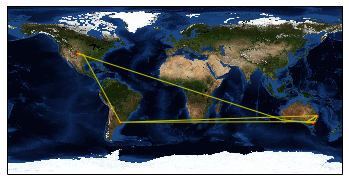

AssertionError: 

In [106]:
graficar_ruta(routeRespose, 'salida.png')

In [129]:
ipCountryCode('129.250.7.69')

u'US'

In [64]:
a = {}
's' in a

False

In [151]:
def f():
    return 'hola', 'claudio'

In [152]:
saludo, nombre = f()

In [153]:
saludo

u'hola'

In [154]:
nombre

u'claudio'

In [14]:
d = pd.DataFrame.from_csv('./df-csv/prueba.csv')

In [15]:
d

,ttl,ip,cc,rtt
host,,,,
www.uq.edu.au,1,empty,empty,0.000000
www.uq.edu.au,2,empty,empty,0.000000
www.uq.edu.au,3,empty,empty,0.000000
www.uq.edu.au,4,empty,empty,0.000000
www.uq.edu.au,5,200.89.161.81,AR,0.069609
www.uq.edu.au,6,200.89.165.1,AR,0.005534
www.uq.edu.au,7,200.89.165.250,AR,0.007442
www.uq.edu.au,8,empty,empty,0.000000
www.uq.edu.au,9,67.17.94.249,US,0.121653
